<a href="https://colab.research.google.com/github/EastbayML/pytorch_tutorial/blob/master/pytorch_tutorial1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


East Bay Machine Learning pytorch tutorial series.

---

We will use this notebook as the launch point for our pytorch tutorial series.


We willl used a google doc as a shared online clipboard. 
https://docs.google.com/document/d/1N-5Ue0rk7g8CImayet-cgnaCkHJzXky7aeHrwUocXEM/edit?usp=sharing


#Agenda
We will be starting with the pytorch.org/tutorials 60 minute blitz and bounce back here occasionally

https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html

Then we will do a brief exploration of deep learning using pytorch autograd

Then we will jump into pytorch.nn

# but first lets start with a little bit of overview (borrowed)

PyTorch vs TensorFlow
* Dynamic vs Static: Though both PyTorch and TensorFlow work on tensors, the primary difference between PyTorch and Tensorflow is that while PyTorch uses dynamic computation graphs, TensorFlow uses static computation graphs. That being said, with the release of TensorFlow 2.0 there has been a major shift towards eager execution, and away from static graph computation. Eager execution in TensorFlow 2.0 evaluates operations immediately, without building graphs.
* Data Parallelism: PyTorch uses asynchronous execution of Python to implement data parallelism, but with TensorFlow this is not the case. With TensorFlow you need to manually configure every operation for data parallelism.
* Visualization Support: TensorFlow has a very good visualization library called TensorBoard. This visualization support helps developers to track the model training process nicely. PyTorch initially had a visualization library called Visdom, but has since provided full support for TensorBoard as well. PyTorch users can utilize TensorBoard to log PyTorch models and metrics within the TensorBoard UI. Scalars, images, histograms, graphs, and embedding visualizations are all supported for PyTorch models and tensors.
* Model Deployment: TensorFlow has great support for deploying models using a framework called TensorFlow serving. It is a framework that uses REST Client API for using the model for prediction once deployed. On the other hand, PyTorch does not provide a framework like serving to deploy models onto the web using REST Client.
https://hub.packtpub.com/what-is-pytorch-and-how-does-it-work/



# why pytorch


https://blog.paperspace.com/why-use-pytorch-deep-learning-framework/

In the recent Kaggle competition, PyTorch library was used by nearly all of the top 10 finishers.

Some of the key highlights of PyTorch includes:

* Simple Interface: It offers easy to use API, thus it is very simple to operate and run like Python.
* Pythonic in nature: This library, being Pythonic, smoothly integrates with the Python data science stack. Thus it can leverage all the services and functionalities offered by the Python environment.
* Computational graphs: In addition to this, PyTorch provides an excellent platform which offers dynamic computational graphs, thus you can change them during runtime. This is highly useful when you have no idea how much memory will be required for creating a neural network model.

* torch.Tensor - A multi-dimensional array with support for autograd operations like backward(). Also holds the gradient w.r.t. the tensor.
* nn.Module - Neural network module. Convenient way of encapsulating parameters, with helpers for moving them to GPU, exporting, loading, etc.
* nn.Parameter - A kind of Tensor, that is automatically registered as a parameter when assigned as an attribute to a Module.
* autograd.Function - Implements forward and backward definitions of an autograd operation. Every Tensor operation, creates at least a single Function node, that connects to functions that created a Tensor and encodes its history.

https://www.analyticsvidhya.com/blog/2019/09/introduction-to-pytorch-from-scratch/


# Setup the environment

In [1]:
!pip install torchviz

     |████████████████████████████████| 51kB 3.9MB/s 
  Created wheel for torchviz: filename=torchviz-0.0.1-cp36-none-any.whl size=3520 sha256=ff52ed970e50d3b48c0bba59fc28e63e35ee619ca1ba09d2278406ac2bf738fc
  Stored in directory: /root/.cache/pip/wheels/2a/c2/c5/b8b4d0f7992c735f6db5bfa3c5f354cf36502037ca2b585667
Successfully built torchviz


In [0]:
from __future__ import print_function
import torch
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
from torchviz import make_dot
import copy
from IPython.core.debugger import set_trace
from IPython.display import clear_output
import math


# Select a device

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


#ENABLE GPU
To enable GPU hardware accelerator, just go to Runtime -> Change runtime type -> Hardware accelerator -> GPU

In [4]:
print("Device is ",device)
x = torch.empty(5, 3)
y = torch.ones_like(x, device=device)  # directly create a tensor on GPU
x = x.to(device)                       # or just use strings ``.to("cuda")``
z = x + y
print(z)
w=z.to("cpu", torch.double)

print("x is cuda ",x.is_cuda)
print("y is cuda ",y.is_cuda)
print("z is cuda ",z.is_cuda)
print("w is cuda ",w.is_cuda)


Device is  cuda
tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]], device='cuda:0')
x is cuda  True
y is cuda  True
z is cuda  True
w is cuda  False


# Benchmarks
Let's compare execution times for numpy, torch cpu and torch gpu

First setup a convenience function.

In [0]:
import timeit
import copy
from functools import partial

def benchmark(stmt,*args):
  number=100
  print("Numpy time   {:.6f}s".format(timeit.timeit(partial(stmt,np,*args),number=1000)/number))
  targs=[torch.tensor(arg,device='cpu') for arg in args]
  print("pytorch time {:.6f}s".format(timeit.timeit(partial(stmt,torch,*targs),number=1000)/number))
  targs=[arg.to(torch.device('cuda')) for arg in targs]
  print("gpu time     {:.6f}s".format(timeit.timeit(partial(stmt,torch,*targs),number=1000)/number))


Next write a simple function to be benchmarked for all three types of variables. Notice that the module name 'np' as the first argument will be replaced with 'torch' for the torch benchmarks. The remaining arguments are expected to be numpy tensors and will be converted to torch tensors for the second benchmark and moved to the gpu for the third benchmark.



In [6]:
def stmt(lib,a,b):
  a=lib.sin(a)
  b=lib.sqrt(b)
  c=a+b


a=np.zeros((300,500))
b=np.zeros((300,500))

benchmark(stmt,a,b)


Numpy time   0.016388s
pytorch time 0.019204s
gpu time     0.000442s


# Numpy shares memory with torch in cpu (but not cuda)

In [7]:
a=torch.zeros((1,2))
c=a.cuda()
b=a.numpy()
a[0,1]=1
print("a ",a)
print("b ",b)
print("c ",c)
try:
  d=c.numpy()
except Exception as e:
  print(e)

a  tensor([[0., 1.]])
b  [[0. 1.]]
c  tensor([[0., 0.]], device='cuda:0')
can't convert CUDA tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.


# Now you do one. 
Do a benchmark of an interesting operation and post it on the shared clipboard. Most math ops are supported. 

https://pytorch.org/docs/stable/tensors.html

https://pytorch.org/docs/stable/nn.functional.html

# Plotting with matplotlib


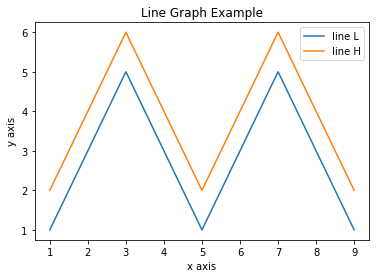

In [8]:
import matplotlib.pyplot as plt
 
x  = [1, 2, 3, 4, 5, 6, 7, 8, 9]
y1 = [1, 3, 5, 3, 1, 3, 5, 3, 1]
y2 = [2, 4, 6, 4, 2, 4, 6, 4, 2]
plt.plot(x, y1, label="line L")
plt.plot(x, y2, label="line H")
plt.plot()
plt.xlabel("x axis")
plt.ylabel("y axis")
plt.title("Line Graph Example")
plt.legend()
plt.show()

# BTW jupyter had as a debugger

Remove the two comment #s and give it a try

%debug

set_trace

In [37]:
#%debug
def fac(x):
  if x<=1:
    return 1
  #set_trace()
  return x*fac(x-1)
fac(10)

3628800

# Graph vizualization

In [10]:
!pip install torchviz

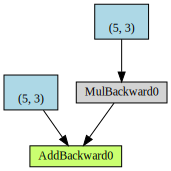

In [11]:
from torchviz import make_dot

x = torch.empty(5, 3,requires_grad=True)
y = torch.empty(5, 3,requires_grad=True)
z = x + y * 10
make_dot(z)


# Now you do one
* Create an interesting pytorch tensor and post the visualization of the call graph.

# Autograd - Try it out.
Test a torch function and verify the gradient is correct.  https://pytorch.org/docs/stable/torch.html#math-operations

Or use the numerical gradient checking to verify a gradient https://pytorch.org/docs/stable autograd.html#numerical-gradient-checking



https://pytorch.org/docs/stable/autograd.html

https://pytorch.org/docs/stable/notes/autograd.html

# Defining new autograd functions

https://pytorch.org/tutorials/beginner/examples_autograd/two_layer_net_custom_function.html

# Deep learning
This is a brief introduction to deep learning using pytorch the autograd feature. While this is a very simple model, the concepts of optimizing a parameterized function are the same as what is used in more complex models.

Once we have a dataset, a model and a loss function defined, we use the autograd feature to move the parameters in a way that reduces the loss for a given training dataset.

# Gradient descent linear regresion example

first create a dataset

In [0]:
# just run on cpu for now
device="cpu"

In [0]:
# Data Generation
def dataset_from_function_with_noise(f,npoints=100,noise=0.1):
  np.random.seed(42)
  x_train_tensor = torch.rand(int(npoints*.8),device=device)
  y_train_tensor = f(x_train_tensor)
  y_train_tensor += torch.randn(y_train_tensor.shape)*noise
  x_val_tensor = torch.rand(int(npoints*.2),device=device)
  y_val_tensor = f(x_train_tensor)
  y_val_tensor += torch.randn(y_val_tensor.shape)*noise
  return x_train_tensor,y_train_tensor,x_val_tensor,y_val_tensor

x_train_tensor,y_train_tensor,x_val_tensor,y_val_tensor = dataset_from_function_with_noise(lambda x:1 + 2 * x  )


Now define function that we would like to fit to this data.  We will start with a linear function.

In [14]:
def model(x):
  return model.a+model.b*x
model.a=torch.randn(1)
model.b=torch.randn(1)

print(vars(model))

{'a': tensor([0.1972]), 'b': tensor([-0.0685])}


# Define gradient descent algorithm.
The gradient descent starts with randomize parameters. Loops through a number of epochs and each loop computes the loss function and the gradient of the loss function with respect to the parameters. Then it adjusts the parameters in a direction that minimizes the loss. It does that by  multiplying the mean of the gradient of the loss function, times a learning rate hyperparameter and adds that to the parameters.

In [0]:
def gd(model,x_train_tensor,y_train_tensor,lr=1e-1,n_epochs=1000):
  initialize_parameters(model)
  for epoch in range(n_epochs): 
    single_step(model,x_train_tensor,y_train_tensor,lr=lr)


def initialize_parameters(model):
  for name,param in vars(model).items():
    setattr(model,name,torch.randn(param.shape, requires_grad=True, dtype=torch.float,device=device))
# define GD optimization

def single_step(model,x_tensor,y_tensor,lr=1e-1,hook=None):
  yhat = model(x_tensor)
  error = y_tensor - yhat
  loss = (error ** 2).mean()
  
  # We just tell PyTorch to work its way BACKWARDS from the specified loss!
  loss.backward()

  # UPDATING the parameters 
  # We need to use NO_GRAD to keep the update out of the gradient computation

  with torch.no_grad():
    for param in vars(model).values():
      param -= lr * param.grad
      param.grad.zero_()

In [16]:
# now test it
gd(model,x_train_tensor,y_train_tensor)
print(vars(model))

{'a': tensor([0.9916], requires_grad=True), 'b': tensor([2.0398], requires_grad=True)}


# Alternative model
The model we define above is a function with attributes.  Functions are objects in python and this is equivalent to defining an object with a __call__ method and attributes. If you prefer using classes, this is the equivalent definition


In [0]:
class Model:
  def __init__(self):
    self.a=torch.randn(1)
    self.b=torch.randn(1)

  def __call__(self,x):
    return self.a+self.b*x

model=Model()

# visualizing GD
Let's see what the solution looks like as the gradient descent optimizes the parameters.

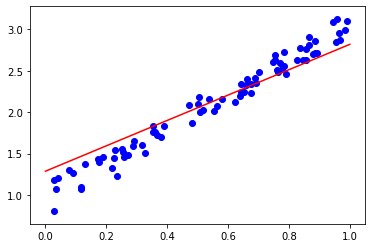

In [18]:
rng=torch.linspace(0,1,10)
artists=[]
fig, ax = plt.subplots()

def gd(model,x_train_tensor,y_train_tensor,lr=1e-1,n_epochs=1000,hook=lambda m,x,y:None):
  initialize_parameters(model)
  for epoch in range(n_epochs): 
    single_step(model,x_train_tensor,y_train_tensor,lr=lr)
    hook(model,x_train_tensor,y_train_tensor)

def movie_hook(model,x_tensor,y_tensor):
  scat=plt.scatter(x_train_tensor,y_train_tensor,c='b')
  l1,=plt.plot(list(rng),list(model(rng)),c='r')
  artists.append([scat,l1])

def plot_hook(model,x_tensor,y_tensor):
  plt.scatter(x_train_tensor,y_train_tensor,c='b')
  plt.plot(list(rng),list(model(rng)),c='r')
  plt.pause(0.5)
  clear_output()   

gd(model,x_train_tensor,y_train_tensor,hook=movie_hook,n_epochs=100)
HTML(animation.ArtistAnimation(fig, artists,interval=50, blit=True,repeat_delay=1000).to_html5_video()) 


# Visualizing the loss function
Lets look at the topology of the loss function. This is the mean of the loss function for the training dataset for different values of the parameters a&b. So the plot is a 2d surface, where color represents the log(mean(loss(a,b))). Notice that the shape is has a sharp gradient in some directions and a low gradient in other directions. This is why we observe that we quickly adjust the parameters at first, but then slowly fine tune the parameters.

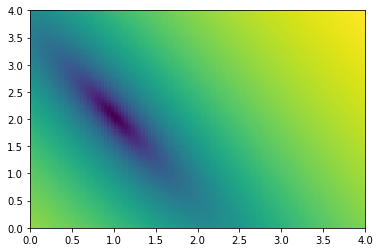

In [19]:
from mpl_toolkits.mplot3d import Axes3D

arng=torch.linspace(0,4,100)
brng=torch.linspace(0,4,100)
av, bv = torch.meshgrid(arng,brng)
def lossf(model,a,b):
    model.a=a
    model.b=b
    yhat = model(x_train_tensor)
    error = y_train_tensor - yhat
    loss = (error ** 2).mean()
    return loss
loss2d=torch.tensor([math.log(lossf(model,a,b)) for b in brng for a in arng])

loss2d=loss2d.reshape(arng.shape[0],brng.shape[0])
ax.set_aspect('equal', 'datalim')
plt.pcolor(arng,brng,loss2d)
plt.show()

# Visualizing GD trajectory over the loss surface

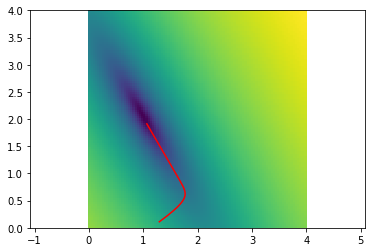

In [20]:
#%debug
rng=torch.linspace(0,1,10)
artists=[]
fig, ax = plt.subplots()
ax.set_aspect('equal', 'datalim')
trajectory=[]
background=plt.pcolor(arng,brng,loss2d)

def trajectory_hook(model,x_tensor,y_tensor):
  trajectory.append((model.a.item(),model.b.item()))  
  l1,=plt.plot(*zip(*trajectory) ,c='r')
  artists.append([l1,background])

gd(model,x_train_tensor,y_train_tensor,hook=trajectory_hook,n_epochs=200)
clear_output()
HTML(animation.ArtistAnimation(fig, artists,interval=50, blit=True,repeat_delay=1000).to_html5_video()) 

# Stochastic Gradient Descent
Technically what we have done so far is not stochastic gradient descent because for every a&b we evaluate the loss function for all values of the training data set.  Stochastic Gradient Descent computes the loss function for a subset of the data and then updates the parameters based on the gradient. So let't define sgd() and see if we get the same answer.

In [0]:
def sgd(model,x_train_tensor,y_train_tensor,batchsize=32,lr=1e-1,n_epochs=1000,hook=lambda m,x,y:None):
  initialize_parameters(model)
  for epoch in range(n_epochs):
    for batch in range(int(n_epochs/batchsize)+1):
      rows = torch.randperm(x_train_tensor.shape[0])[:batchsize]
      single_step(model,x_train_tensor[rows],y_train_tensor[rows])
    hook(model,x_train_tensor,y_train_tensor)

In [22]:
sgd(model,x_train_tensor,y_train_tensor)
print(vars(model))

{'a': tensor(0.9937, requires_grad=True), 'b': tensor(2.0388, requires_grad=True)}


# now lets visualize SGD

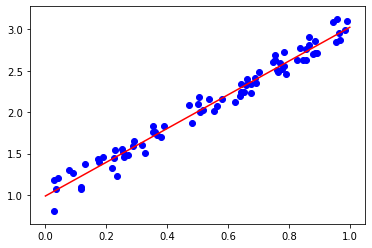

In [23]:

rng=torch.linspace(0,1,10)
artists=[]
fig, ax = plt.subplots()
sgd(model,x_train_tensor,y_train_tensor,hook=movie_hook)
HTML(animation.ArtistAnimation(fig, artists,interval=50, blit=True,repeat_delay=1000).to_html5_video()) 

# Model complexity
Let's try fitting a more complex dataset. Define our dataset and our model here.

In [0]:
x_train_tensor,y_train_tensor,x_val_tensor,y_val_tensor = dataset_from_function_with_noise(lambda x:1 + .2 * x + x**2  )


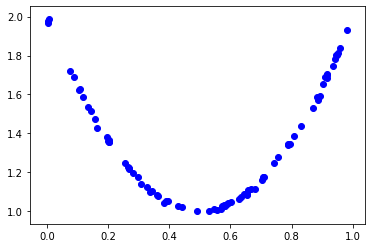

In [35]:
def model(x):
  return model.a+model.b*x+model.c*x**2+model.d*x**3
model.a=torch.randn(1)
model.b=torch.randn(1)
model.c=torch.randn(1)
model.d=torch.randn(1)

plt.scatter(x_train_tensor,y_train_tensor,c='b')
plt.show()

Now train the model

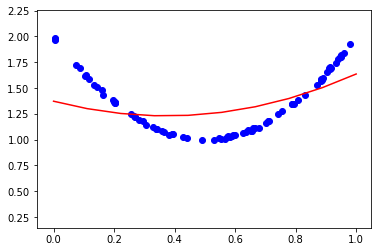

In [36]:
rng=torch.linspace(0,1,10)
artists=[]
fig, ax = plt.subplots()
sgd(model,x_train_tensor,y_train_tensor,hook=movie_hook,n_epochs=100)
HTML(animation.ArtistAnimation(fig, artists,interval=50, blit=True,repeat_delay=1000).to_html5_video()) 

# deep learning models 
often use layers of linear and nonlinear functions with hidden activation layers. Lets try that now.



we need to change some of our utility functions to work with tensors instead of scalars


In [0]:
# Data Generation
def vector_dataset_from_function_with_noise(f,npoints=100,noise=0.1):
  np.random.seed(42)
  x_train_tensor = torch.rand((int(npoints*.8),1),device=device)
  y_train_tensor = f(x_train_tensor)
  y_train_tensor += torch.randn(y_train_tensor.shape)*noise
  x_val_tensor = torch.rand((int(npoints*.2),1),device=device)
  y_val_tensor = f(x_train_tensor)
  y_val_tensor += torch.randn(y_val_tensor.shape)*noise
  return x_train_tensor,y_train_tensor,x_val_tensor,y_val_tensor


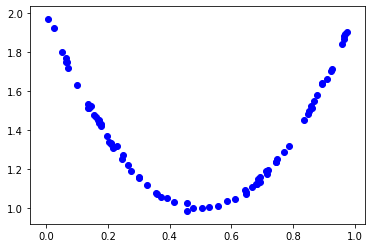

In [29]:
x_train_tensor,y_train_tensor,x_val_tensor,y_val_tensor = vector_dataset_from_function_with_noise(lambda x:1 + 4 * (x-0.5)**2,noise=0.01 ,npoints=100 )
plt.scatter(x_train_tensor,y_train_tensor,c='b')
plt.show()

In [0]:
def model(x):
  if len(x.shape)==1:
    x=x.unsqueeze(-1)
  h1 = model.w1.mm(x.T).T +model.b1
  a1 = torch.relu(h1)
  h2 = model.w2.mm(a1.T).T+model.b2
  return h2
hl=10
model.w1=torch.randn((hl,1))
model.b1=torch.randn((hl))
model.w2=torch.randn((1,hl))
model.b2=torch.randn((1,))


Now train the model

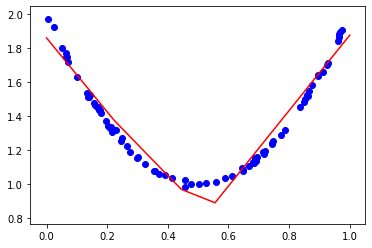

In [31]:

rng=torch.linspace(0,1,10)
artists=[]
fig, ax = plt.subplots()
sgd(model,x_train_tensor,y_train_tensor,hook=movie_hook,n_epochs=300,lr=1e-2)
HTML(animation.ArtistAnimation(fig, artists,interval=50, blit=True,repeat_delay=1000).to_html5_video()) 

# initialization matters
In my tests, the sgd only converges occasionally. I think this is because of parameter initialization values as described here https://towardsdatascience.com/understand-kaiming-initialization-and-implementation-detail-in-pytorch-f7aa967e9138

# OK. Lets play with pytorch.nn
* torch.Tensor is like numpy
* torch.nn,torch.optim,torch.loss,torch.data are like keras

* torch.nn.Model is a container for parameters (torch.nn.Parameters) and a forward(x) function. It may also include additional sub models.
https://pytorch.org/docs/stable/nn.html


Thanks to 
https://medium.com/@benjamin.phillips22/simple-regression-with-neural-networks-in-pytorch-313f06910379 for the example.

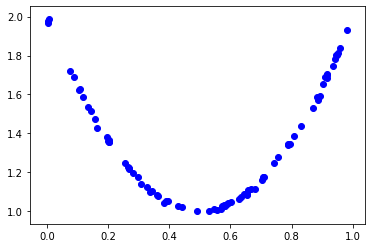

In [32]:
torch.manual_seed(42)
x_train_tensor,y_train_tensor,x_val_tensor,y_val_tensor = vector_dataset_from_function_with_noise(lambda x:1 + 4 * (x-0.5)**2,noise=0.01 ,npoints=100 )
plt.scatter(x_train_tensor,y_train_tensor,c='b')
plt.show()

Net(
  (fc1): Linear(in_features=1, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=1, bias=True)
)


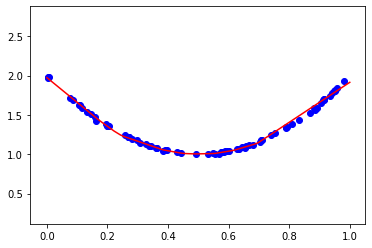

In [33]:
import torch.optim as optim
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils import data

my_dataset = data.TensorDataset(x_train_tensor,y_train_tensor) # create your datset
my_dataloader = data.DataLoader(my_dataset,batch_size=64) 

torch.manual_seed(42)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1, 100)
        self.fc2 = nn.Linear(100, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net = Net()
print(net)

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.02)

rng=torch.linspace(0,1,100).unsqueeze(-1)

artists=[]
fig, ax = plt.subplots()
scat=plt.scatter(x_train_tensor,y_train_tensor,c='b')

n_epochs=100
for i in range(n_epochs):
  for X,Y in my_dataloader:
    Yhat = net(X)
    loss = criterion(Yhat, Y)
    optimizer.zero_grad()   # zero the gradient buffers
    loss.backward()
    optimizer.step()    # Does the update

    l1,=plt.plot(list(rng),list(net(rng)),c='r')
    artists.append([scat,l1])


HTML(animation.ArtistAnimation(fig, artists,interval=50, blit=True,repeat_delay=1000).to_html5_video()) 

# Now your turn.

Play with optimizers, loss functions,learning rate, target signal, target noise, # points, batchsize, epochs ,model structure, etc. Try it on a GPU.

Find an interesting result and post it to the shared board. Try to keep training time down so we can share during class.

optimizers:https://pytorch.org/docs/stable/optim.html

loss functions: https://pytorch.org/docs/stable/nn.functional.html#loss-functions

torch functions: https://pytorch.org/docs/stable/nn.functional.html

data utilities: (to be explored in later session) https://pytorch.org/docs/stable/data.html


# Question

Why doesnt the linear model above use all of the hidden layer activations to make a closer fit?

* I tried 3000 epoch and it never improved

## Links and stuff


In [34]:
#%debug
def fac(x):
  if x<=1:
    return 1
  #set_trace()
  return x*fac(x-1)
fac(10)

> <ipython-input-25-a0c5cf106f85>(2)model()
      1 def model(x):
----> 2   return model.a+model.b*x+model.c*x**+model.d*x**3
      3 model.a=torch.randn(1)
      4 model.b=torch.randn(1)
      5 model.c=torch.randn(1)

--KeyboardInterrupt--
--KeyboardInterrupt--
ipdb> 

> <ipython-input-34-a65e55c990ea>(6)fac()
      3   if x<=1:
      4     return 1
      5   set_trace()
----> 6   return x*fac(x-1)
      7 fac(10)

ipdb> 



BdbQuit: ignored


https://blog.paperspace.com/why-use-pytorch-deep-learning-framework/


https://hub.packtpub.com/what-is-pytorch-and-how-does-it-work/

https://pytorch.org/docs/master/named_tensor.html
https://en.wikipedia.org/wiki/Automatic_differentiation
https://pytorch.org/tutorials/beginner/examples_autograd/two_layer_net_custom_function.html
https://github.com/pytorch/pytorch/blob/master/torch/nn/modules/module.py
https://www.analyticsvidhya.com/blog/2019/09/introduction-to-pytorch-from-scratch/




![alt text](https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2019/09/dynamic_graph.gif)